### Create a spark session and import the required libraries

In [ ]:
import findspark
findspark.init()
import pyspark
from pyspark.sql import SparkSession
from pyspark.sql.functions import *
from pyspark.sql.types import *

In [ ]:
spark = SparkSession.builder.appName("Final Exam").getOrCreate()

### Create a data schema programatically

In [ ]:
schema = StructType([StructField("id", IntegerType(), False),
                     StructField("gender", StringType(), False),
                     StructField("age", DoubleType(), False),
                     StructField("hypertension", IntegerType(), False),
                     StructField("heart_disease", IntegerType(), False),
                     StructField("ever_married", StringType(), False),
                     StructField("work_type", StringType(), False),
                     StructField("Residence_type", StringType(), False),
                     StructField("avg_glucose_level", DoubleType(), False),
                     StructField("bmi", DoubleType(), False),
                     StructField("smoking_status", StringType(), False),
                     StructField("stroke", IntegerType(), False)])

### Read the data using the standard DataReader (Key,Value) pairs format
- Provide the schema and any other required options.

In [ ]:
health_df = spark.read.csv("healthcare-dataset-stroke-data.csv", header="true", schema=schema, inferSchema="true")

### Explore the data 
#### You have to do the following:
- Print the Schema.
- Show the first 10 rows from the data.
- Explore null values and show how many null values in each column.
- Plot a count plot for the target label and <b>notice the graph</b>.
- Perform any additional EDA you find useful.

In [ ]:
health_df.printSchema()

root
 |-- id: integer (nullable = true)
 |-- gender: string (nullable = true)
 |-- age: double (nullable = true)
 |-- hypertension: integer (nullable = true)
 |-- heart_disease: integer (nullable = true)
 |-- ever_married: string (nullable = true)
 |-- work_type: string (nullable = true)
 |-- Residence_type: string (nullable = true)
 |-- avg_glucose_level: double (nullable = true)
 |-- bmi: double (nullable = true)
 |-- smoking_status: string (nullable = true)
 |-- stroke: integer (nullable = true)



In [ ]:
health_df.show(10)

+-----+------+----+------------+-------------+------------+-------------+--------------+-----------------+----+---------------+------+
|   id|gender| age|hypertension|heart_disease|ever_married|    work_type|Residence_type|avg_glucose_level| bmi| smoking_status|stroke|
+-----+------+----+------------+-------------+------------+-------------+--------------+-----------------+----+---------------+------+
| 9046|  Male|67.0|           0|            1|         Yes|      Private|         Urban|           228.69|36.6|formerly smoked|     1|
|51676|Female|61.0|           0|            0|         Yes|Self-employed|         Rural|           202.21|null|   never smoked|     1|
|31112|  Male|80.0|           0|            1|         Yes|      Private|         Rural|           105.92|32.5|   never smoked|     1|
|60182|Female|49.0|           0|            0|         Yes|      Private|         Urban|           171.23|34.4|         smokes|     1|
| 1665|Female|79.0|           1|            0|         

In [ ]:
null_cols = []

for c in health_df.columns:
    
    nulls = health_df.where(col(c).isNull()).count()
    
    if(nulls > 0):
        null_cols.append((c, nulls))
        
print(null_cols)

[('bmi', 201)]


In [ ]:
import seaborn as sns

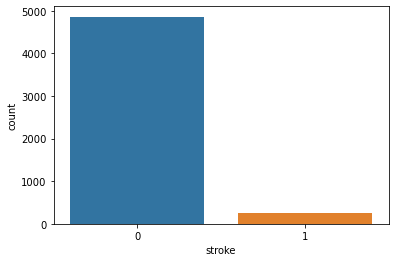

In [ ]:
sns.countplot(x = health_df.toPandas().stroke);

### Get the summary statistics of the age column
- You will find the minimum age is about <b>0.08</b>.
- Remove rows for the age below <b>2 years old</b>.

In [ ]:
health_df.describe(['age']).show()

+-------+------------------+
|summary|               age|
+-------+------------------+
|  count|              5110|
|   mean|43.226614481409015|
| stddev| 22.61264672311348|
|    min|              0.08|
|    max|              82.0|
+-------+------------------+



In [ ]:
health_df_1 = health_df.where(col('age') >= 2 )

In [ ]:
health_df_1.describe(['age']).show()

+-------+------------------+
|summary|               age|
+-------+------------------+
|  count|              4990|
|   mean| 44.23907815631262|
| stddev|21.908077881917443|
|    min|               2.0|
|    max|              82.0|
+-------+------------------+



### Working with gender & smoking_status columns:
- Select and show the gender & smoking_status columns
- Get the distinct values for each column.

In [ ]:
health_df_1.select(col('gender'),col('smoking_status')).show()

+------+---------------+
|gender| smoking_status|
+------+---------------+
|  Male|formerly smoked|
|Female|   never smoked|
|  Male|   never smoked|
|Female|         smokes|
|Female|   never smoked|
|  Male|formerly smoked|
|  Male|   never smoked|
|Female|   never smoked|
|Female|        Unknown|
|Female|        Unknown|
|Female|   never smoked|
|Female|         smokes|
|Female|         smokes|
|  Male|        Unknown|
|Female|   never smoked|
|Female|   never smoked|
|  Male|         smokes|
|  Male|         smokes|
|Female|   never smoked|
|  Male|        Unknown|
+------+---------------+
only showing top 20 rows



In [ ]:
health_df_1.select(col('gender')).distinct().show()

+------+
|gender|
+------+
|Female|
| Other|
|  Male|
+------+



In [ ]:
health_df_1.select(col('smoking_status')).distinct().show()

+---------------+
| smoking_status|
+---------------+
|         smokes|
|        Unknown|
|   never smoked|
|formerly smoked|
+---------------+



#### Change the string values of the columns into numerical values as follow:
1. Gender column:
    * Male = 1 
    * Female = 0 
    * Other = 0 
2. Smoking Status column:
  * never smoked = 0
  * Unknown = 0.5
  * formerly smoked = 0.75
  * smokes = 1.0


In [ ]:
def numiraize_gender (col):
    return 1 if col == 'Male' else 0
    
gender_num = udf( numiraize_gender , IntegerType())

In [ ]:
health_df_2 = health_df_1.withColumn('gender', gender_num('gender'))

In [ ]:
def numiraize_smoking_status(col):
    if col == 'never smoked':
        return 0.0
    elif col == 'Unknown':
        return 0.5
    elif col== 'formerly smoked':
        return 0.75
    else:
        return 1.0

    
smoking_status_num = udf( numiraize_smoking_status , DoubleType())

In [ ]:
health_df_3 = health_df_2.withColumn('smoking_status', smoking_status_num('smoking_status'))

#### Show the output DataFrame
- Select and show the gender & smoking_status columns after value changing.
- Print schema for the new dataframe.

In [ ]:
health_df_3.select(col('gender'),col('smoking_status')).show()

+------+--------------+
|gender|smoking_status|
+------+--------------+
|     1|          0.75|
|     0|           0.0|
|     1|           0.0|
|     0|           1.0|
|     0|           0.0|
|     1|          0.75|
|     1|           0.0|
|     0|           0.0|
|     0|           0.5|
|     0|           0.5|
|     0|           0.0|
|     0|           1.0|
|     0|           1.0|
|     1|           0.5|
|     0|           0.0|
|     0|           0.0|
|     1|           1.0|
|     1|           1.0|
|     0|           0.0|
|     1|           0.5|
+------+--------------+
only showing top 20 rows



### Deal with null value according to your data analysis.

In [ ]:
#mean = health_df_3.agg({'bmi': 'mean'}).collect()[0][0]
#health_df_4 = health_df_3.fillna(mean, subset=['bmi'])
health_df_4 = health_df_3.dropna()

In [ ]:
null_cols = []

for c in health_df_4.columns:
    
    nulls = health_df_4.where(col(c).isNull()).count()
    
    if(nulls > 0):
        null_cols.append((c, nulls))
        
print(null_cols)

[]


### Split the data into training and test dataframes:
- 80% training and 20% test.
- seed = 42.
- Save each dataframe as a parquet file

In [ ]:
trainDF, testDF = health_df_4.randomSplit([0.8, 0.2], seed = 42)

In [ ]:
# trainDF.write.parquet("trainDF.parquet")
# testDF.write.parquet("testDF.parquet")

### Read the saved Train and Test DataFrame:
- Use the dataframes you read in the subsequent steps.

In [ ]:
trainDF = spark.read.parquet("trainDF.parquet")
testDF = spark.read.parquet("testDF.parquet")

### Create the model:
- Perform feature engineering steps.
- Create the logistic regression classifier.
- Build the pipeline model that uses all feature engineering steps and the model.
- Train the pipeline model using the trainig dataset.

In [ ]:
categoricalCols = [field for (field, dataType) in trainDF.dtypes if dataType == "string"]
indexOutputCols = [x + "_Index" for x in categoricalCols]
oheOutputCols = [x + "_OHE" for x in categoricalCols]

numericCols = [field for (field,dataType) in trainDF.dtypes if ((dataType=='double')& (field!='price'))]

In [ ]:
categoricalCols

['ever_married', 'work_type', 'Residence_type']

In [ ]:
numericCols

['age', 'avg_glucose_level', 'bmi', 'smoking_status']

In [ ]:
from pyspark.ml.feature import StringIndexer, VectorAssembler, OneHotEncoder

In [ ]:
stringIndexer = StringIndexer(inputCols=categoricalCols,outputCols=indexOutputCols,handleInvalid='skip')
oheEncoder = OneHotEncoder(inputCols=indexOutputCols, outputCols=oheOutputCols)

In [ ]:
assemblerInputs = oheOutputCols + numericCols + ['gender','hypertension','heart_disease']
vecAssembler = VectorAssembler(inputCols=assemblerInputs,outputCol='features')

In [ ]:
from pyspark.ml import Pipeline
from pyspark.ml.classification import LogisticRegression

In [ ]:
LR = LogisticRegression(featuresCol = 'features', labelCol = 'stroke', maxIter=10)

In [ ]:
pipeline = Pipeline(stages=[stringIndexer,oheEncoder,vecAssembler,LR])
pipelineModel = pipeline.fit(trainDF)

### Perform predictions on tests dataframe:
- Test the model using the test dataframe
- Select and show the feature column.
- Print the schema of the output dataframe.
- Select and show both prediction and label columns.
- Explore the results for the label column stroke=1. i.e. select both columns (prediction,stroke) for stroke=1.<b>notice the result.</b> 
- Count the predicted 1 and 0 values.<b>notice the result.</b>   

In [ ]:
predDF = pipelineModel.transform(testDF)

In [ ]:
predDF.select(col('features')).show()

+--------------------+
|            features|
+--------------------+
|(13,[0,1,5,6,7,8,...|
|(13,[1,5,6,7,8],[...|
|(13,[0,1,6,7,8],[...|
|(13,[0,1,6,7,8,9]...|
|(13,[0,1,5,6,7,8,...|
|(13,[0,1,6,7,8],[...|
|(13,[0,2,6,7,8,10...|
|(13,[0,2,5,6,7,8]...|
|(13,[4,6,7,8,9],[...|
|(13,[0,1,6,7,8,9,...|
|(13,[0,3,6,7,8,9,...|
|(13,[1,6,7,8,9,11...|
|(13,[1,6,7,8,10],...|
|(13,[0,2,6,7,8,9]...|
|(13,[0,1,6,7,8,11...|
|(13,[0,3,5,6,7,8,...|
|(13,[1,5,6,7,8],[...|
|[1.0,1.0,0.0,0.0,...|
|[1.0,0.0,0.0,1.0,...|
|(13,[1,5,6,7,8],[...|
+--------------------+
only showing top 20 rows



In [ ]:
predDF.printSchema()

root
 |-- id: integer (nullable = true)
 |-- gender: integer (nullable = true)
 |-- age: double (nullable = true)
 |-- hypertension: integer (nullable = true)
 |-- heart_disease: integer (nullable = true)
 |-- ever_married: string (nullable = true)
 |-- work_type: string (nullable = true)
 |-- Residence_type: string (nullable = true)
 |-- avg_glucose_level: double (nullable = true)
 |-- bmi: double (nullable = true)
 |-- smoking_status: double (nullable = true)
 |-- stroke: integer (nullable = true)
 |-- ever_married_Index: double (nullable = false)
 |-- work_type_Index: double (nullable = false)
 |-- Residence_type_Index: double (nullable = false)
 |-- ever_married_OHE: vector (nullable = true)
 |-- work_type_OHE: vector (nullable = true)
 |-- Residence_type_OHE: vector (nullable = true)
 |-- features: vector (nullable = true)
 |-- rawPrediction: vector (nullable = true)
 |-- probability: vector (nullable = true)
 |-- prediction: double (nullable = false)



In [ ]:
predDF.select(col('stroke'),col('prediction')).show()

+------+----------+
|stroke|prediction|
+------+----------+
|     0|       0.0|
|     0|       0.0|
|     0|       0.0|
|     0|       0.0|
|     0|       0.0|
|     0|       0.0|
|     0|       0.0|
|     1|       0.0|
|     0|       0.0|
|     0|       0.0|
|     0|       0.0|
|     1|       0.0|
|     0|       0.0|
|     0|       0.0|
|     0|       0.0|
|     0|       0.0|
|     0|       0.0|
|     0|       0.0|
|     0|       0.0|
|     0|       0.0|
+------+----------+
only showing top 20 rows



In [ ]:
predDF.groupBy("stroke").count().show()

+------+-----+
|stroke|count|
+------+-----+
|     1|   46|
|     0|  907|
+------+-----+



In [ ]:
predDF.groupBy("prediction").count().show()

+----------+-----+
|prediction|count|
+----------+-----+
|       0.0|  953|
+----------+-----+



### Evaluate the model performance
- Use <b>BinaryClassificationEvaluator</b>. This will calculate the <b>ROC</b>.
- Set the parameters as follow:
    - <b>rawPredictionCol='prediction'</b> and <b>labelCol='stroke'</b>

In [ ]:
from pyspark.ml.evaluation import BinaryClassificationEvaluator

In [ ]:
evaluatorROC = BinaryClassificationEvaluator(rawPredictionCol='prediction'
                                             ,labelCol='stroke')

In [ ]:
evaluatorROC.evaluate(predDF)

0.5

### Improve Model Performance
- You may noticed that <b>the target label is imbalanced</b>.
- LogisticRegression classifier has a special parameter <b>weightCol</b> to deal with imbalanced class.
- In order to use this parameter you must have a <b>weightCol</b> in your training dataframe.
- In order to create this column you will need to define a <b>UDF</b> and apply it to the target label column.
- Create a LogisticRegression classifier with <b>weightCol</b> parameter.
- Build and train a pipeline model with the new LogisticRegression.
- Perform the prediction on the test dataframe. 
- Select and show both prediction and label columns.
- Explore the results for the label column stroke=1. i.e. select both columns (prediction,stroke) for stroke=1.<b>notice the result.</b> 
- Count the predicted 1 and 0 values.<b>notice the result.</b>   
- Evaluate the model performance exactly as in the previous step.
<BR>


In [ ]:
ones = health_df_4.groupBy("stroke").count().collect()[0][1]
zeros = health_df_4.groupBy("stroke").count().collect()[1][1]
full = ones + zeros

def weighted_col(x):
    if x == 0:
        return (ones / full)
    else:
        return (zeros / full)
    
    
w_col_func = udf(weighted_col, DoubleType())


In [ ]:
trainDF_1 = trainDF.withColumn('weighted_col', w_col_func('stroke'))

In [ ]:
trainDF_1.select(col('stroke'), col('weighted_col')).show()

+------+-------------------+
|stroke|       weighted_col|
+------+-------------------+
|     0|0.04358706986444213|
|     0|0.04358706986444213|
|     0|0.04358706986444213|
|     0|0.04358706986444213|
|     0|0.04358706986444213|
|     0|0.04358706986444213|
|     0|0.04358706986444213|
|     0|0.04358706986444213|
|     0|0.04358706986444213|
|     0|0.04358706986444213|
|     1| 0.9564129301355578|
|     0|0.04358706986444213|
|     0|0.04358706986444213|
|     0|0.04358706986444213|
|     0|0.04358706986444213|
|     0|0.04358706986444213|
|     0|0.04358706986444213|
|     0|0.04358706986444213|
|     0|0.04358706986444213|
|     0|0.04358706986444213|
+------+-------------------+
only showing top 20 rows



In [ ]:
LR_2 = LogisticRegression(featuresCol = 'features', labelCol = 'stroke', weightCol = 'weighted_col')

In [ ]:
pipeline_2 = Pipeline(stages=[stringIndexer,oheEncoder,vecAssembler,LR_2])
pipelineModel_2 = pipeline_2.fit(trainDF_1)

In [ ]:
predDF_2 = pipelineModel_2.transform(testDF)

In [ ]:
evaluatorROC.evaluate(predDF_2)

0.7929509611236278